# Problematic Internet Use & Physical Activity

### Setup & imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, warnings
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline   # NOTE: from imblearn, not sklearn!
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, cohen_kappa_score
from concurrent.futures import ThreadPoolExecutor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.metrics import cohen_kappa_score,confusion_matrix,make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import ConfusionMatrixDisplay
from collections import Counter
import optuna

from imblearn.over_sampling import SMOTE




from sklearn.ensemble import StackingClassifier, RandomForestClassifier




pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Data loading & initial overview

In [2]:
# Suppress warnings
warnings.filterwarnings('ignore')

# Pandas option for displaying all columns
pd.options.display.max_columns = None

def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    stats, indexes = zip(*results)
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df

# Load datasets
train = pd.read_csv('C:/MY_Masters_Project/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('C:/MY_Masters_Project/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('C:/MY_Masters_Project/child-mind-institute-problematic-internet-use/sample_submission.csv')

# Load time series data
train_ts = load_time_series("C:/MY_Masters_Project/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("C:/MY_Masters_Project/child-mind-institute-problematic-internet-use/series_test.parquet")

# Merge datasets
time_series_cols = train_ts.columns.tolist()
time_series_cols.remove('id')
train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

100%|██████████| 2/2 [00:00<00:00, 15.69it/s]


In [3]:
train.head()

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,stat_0,stat_1,stat_2,stat_3,stat_4,stat_5,stat_6,stat_7,stat_8,stat_9,stat_10,stat_11,stat_12,stat_13,stat_14,stat_15,stat_16,stat_17,stat_18,stat_19,stat_20,stat_21,stat_22,stat_23,stat_24,stat_25,stat_26,stat_27,stat_28,stat_29,stat_30,stat_31,stat_32,stat_33,stat_34,stat_35,stat_36,stat_37,stat_38,stat_39,stat_40,stat_41,stat_42,stat_43,stat_44,stat_45,stat_46,stat_47,stat_48,stat_49,stat_50,stat_51,stat_52,stat_53,stat_54,stat_55,stat_56,stat_57,stat_58,stat_59,stat_60,stat_61,stat_62,stat_63,stat_64,stat_65,stat_66,stat_67,stat_68,stat_69,stat_70,stat_71,stat_72,stat_73,stat_74,stat_75,stat_76,stat_77,stat_78,stat_79,stat_80,stat_81,stat_82,stat_83,stat_84,stat_85,stat_86,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95
0,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,Fall,5.0,4.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,5.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0,NaN,NaN,NaN,NaN,NaN,

In [4]:
test.head()

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,stat_0,stat_1,stat_2,stat_3,stat_4,stat_5,stat_6,stat_7,stat_8,stat_9,stat_10,stat_11,stat_12,stat_13,stat_14,stat_15,stat_16,stat_17,stat_18,stat_19,stat_20,stat_21,stat_22,stat_23,stat_24,stat_25,stat_26,stat_27,stat_28,stat_29,stat_30,stat_31,stat_32,stat_33,stat_34,stat_35,stat_36,stat_37,stat_38,stat_39,stat_40,stat_41,stat_42,stat_43,stat_44,stat_45,stat_46,stat_47,stat_48,stat_49,stat_50,stat_51,stat_52,stat_53,stat_54,stat_55,stat_56,stat_57,stat_58,stat_59,stat_60,stat_61,stat_62,stat_63,stat_64,stat_65,stat_66,stat_67,stat_68,stat_69,stat_70,stat_71,stat_72,stat_73,stat_74,stat_75,stat_76,stat_77,stat_78,stat_79,stat_80,stat_81,stat_82,stat_83,stat_84,stat_85,stat_86,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95
0,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,

In [5]:
train.shape,test.shape

((3960, 177), (20, 154))

In [6]:
train_ts.shape,test_ts.shape


((996, 97), (2, 97))

In [7]:
missing_cols=set(train)-set(test)
missing_cols.remove('sii')
missing_cols

{'PCIAT-PCIAT_01',
 'PCIAT-PCIAT_02',
 'PCIAT-PCIAT_03',
 'PCIAT-PCIAT_04',
 'PCIAT-PCIAT_05',
 'PCIAT-PCIAT_06',
 'PCIAT-PCIAT_07',
 'PCIAT-PCIAT_08',
 'PCIAT-PCIAT_09',
 'PCIAT-PCIAT_10',
 'PCIAT-PCIAT_11',
 'PCIAT-PCIAT_12',
 'PCIAT-PCIAT_13',
 'PCIAT-PCIAT_14',
 'PCIAT-PCIAT_15',
 'PCIAT-PCIAT_16',
 'PCIAT-PCIAT_17',
 'PCIAT-PCIAT_18',
 'PCIAT-PCIAT_19',
 'PCIAT-PCIAT_20',
 'PCIAT-PCIAT_Total',
 'PCIAT-Season'}

In [8]:
train.isna().sum()

Basic_Demos-Enroll_Season                    0
Basic_Demos-Age                              0
Basic_Demos-Sex                              0
CGAS-Season                               1405
CGAS-CGAS_Score                           1539
Physical-Season                            650
Physical-BMI                               938
Physical-Height                            933
Physical-Weight                            884
Physical-Waist_Circumference              3062
Physical-Diastolic_BP                     1006
Physical-HeartRate                         993
Physical-Systolic_BP                      1006
Fitness_Endurance-Season                  2652
Fitness_Endurance-Max_Stage               3217
Fitness_Endurance-Time_Mins               3220
Fitness_Endurance-Time_Sec                3220
FGC-Season                                 614
FGC-FGC_CU                                1638
FGC-FGC_CU_Zone                           1678
FGC-FGC_GSND                              2886
FGC-FGC_GSND_

### Missing value analysis & cleaning

#####  Dropping features

In [9]:
# dropping features with equal to or more than 50% of missing values
def dropMissingValueFeatures(train,test):
    missing_train = train.isna().mean() * 100
    cols_to_drop = missing_train[missing_train >= 50].index.tolist()
    cols_to_drop+=[i for i in train.columns if 'BIA' in i]

    train=train.drop(columns=[col for col in cols_to_drop if col in train.columns], axis=1)
    test=test.drop(columns=[col for col in cols_to_drop if col in test.columns], axis=1)
    return train,test

In [10]:
train,test=dropMissingValueFeatures(train,test)

In [11]:
missing_train = train.isna().mean() * 100
missing_test = test.isna().mean() * 100

print("Columns with missing values in df_train:")
print(missing_train[missing_train >0])

print("\nColumns with missing values in df_test:")
print(missing_test[missing_test >0])

Columns with missing values in df_train:
CGAS-Season                               35.479798
CGAS-CGAS_Score                           38.863636
Physical-Season                           16.414141
Physical-BMI                              23.686869
Physical-Height                           23.560606
Physical-Weight                           22.323232
Physical-Diastolic_BP                     25.404040
Physical-HeartRate                        25.075758
Physical-Systolic_BP                      25.404040
FGC-Season                                15.505051
FGC-FGC_CU                                41.363636
FGC-FGC_CU_Zone                           42.373737
FGC-FGC_PU                                41.666667
FGC-FGC_PU_Zone                           42.651515
FGC-FGC_SRL                               41.792929
FGC-FGC_SRL_Zone                          42.752525
FGC-FGC_SRR                               41.742424
FGC-FGC_SRR_Zone                          42.702020
FGC-FGC_TL             

In [12]:
train.shape[1]-test.shape[1]

23

In [13]:
wa = pd.DataFrame(data=train, columns=['PCIAT-PCIAT_Total', 'sii'])
wa[pd.notna(wa['PCIAT-PCIAT_Total'])]

,PCIAT-PCIAT_Total,sii
0,55.0,2.0
1,0.0,0.0
2,28.0,0.0
3,44.0,1.0
5,34.0,1.0
...,...,...
3953,22.0,0.0
3954,33.0,1.0
3955,32.0,1.0
3957,31.0,1.0


In [14]:
train_pciatAvg=train.copy()
test_pciatAvg=test.copy()
pciat_columns = [f'PCIAT-PCIAT_{i:02d}' for i in range(1, 21)]
train_pciatAvg['Pciat_total_min']=train_pciatAvg[pciat_columns].fillna(0).sum(axis=1)
train_pciatAvg['Pciat_total_max']=train_pciatAvg[pciat_columns].fillna(5).sum(axis=1)
train_pciatAvg['Pciat_total_avg']=(train_pciatAvg['Pciat_total_max']+train_pciatAvg['Pciat_total_min'])/2
train_pciatAvg.drop(columns=['Pciat_total_max','Pciat_total_min','PCIAT-PCIAT_Total', 'PCIAT-Season','sii'] + pciat_columns, inplace=True)

def calSii(total):
    if total<=30:
        return 0  # None
    elif 31 <= total <= 49:
        return 1  # Mild
    elif 50 <= total <= 79:
        return 2  # Moderate
    else:
        return 3  # Severe

train_pciatAvg['sii_pred']=train_pciatAvg['Pciat_total_avg'].apply(calSii)
train_pciatAvg.drop('Pciat_total_avg',axis=1)

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii_pred
0,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,Fall,0.0,0.0,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,NaN,NaN,NaN,Fall,3.0,2
1,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,75.0,70.0,122.0,Fall,3.0,0.0,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Fall,46.0,64.0,Summer,0.0,0
2,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,65.0,94.0,117.0,Fall,20.0,1.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,Fall,38.0,54.0,Summer,2.0,0
3,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,60.0,97.0,117.0,Summer,18.0,1.0,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,31.0,45.0,Winter,0.0,1
4,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,Fall,13,0,Spring,60.0,Fall,16.362460,59.5,82.4,71.0,70.0,104.0,Fall,16.0,0.0,10.0,1.0,8.0,1.0,9.0,1.0,12.0,1.0,Winter,35.0,50.0,Fall,1.0,1
3956,Winter,10,0,NaN,NaN,Spring,18.764678,53.5,76.4,60.0,78.0,118.0,Spring,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,12.0,1.0,NaN,NaN,NaN,Winter,0.0,2
3957,Fall,11,0,Spring,68.0,Winter,21.441500,60.0,109.8,79.0,99.0,116.0,Winter,15.0,1.0,0.0,0.0,10.0,1.0,10.0,1.0,14.0,1.0,Winter,56.0,77.0,Fall,0.0,1
3958,Spring,13,0,Spring,70.0,Winter,12.235895,70.7,87.0,59.0,61.0,113.0,Spring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spring,33.0,47.0,Spring,1.0,0


In [15]:
missing_train = train_pciatAvg.isna().mean() * 100
missing_test = test.isna().mean() * 100

print("Columns with missing values in df_train:")
print(missing_train[missing_train >0])

print("\nColumns with missing values in df_test:")
print(missing_test[missing_test >0])

Columns with missing values in df_train:
CGAS-Season                               35.479798
CGAS-CGAS_Score                           38.863636
Physical-Season                           16.414141
Physical-BMI                              23.686869
Physical-Height                           23.560606
Physical-Weight                           22.323232
Physical-Diastolic_BP                     25.404040
Physical-HeartRate                        25.075758
Physical-Systolic_BP                      25.404040
FGC-Season                                15.505051
FGC-FGC_CU                                41.363636
FGC-FGC_CU_Zone                           42.373737
FGC-FGC_PU                                41.666667
FGC-FGC_PU_Zone                           42.651515
FGC-FGC_SRL                               41.792929
FGC-FGC_SRL_Zone                          42.752525
FGC-FGC_SRR                               41.742424
FGC-FGC_SRR_Zone                          42.702020
FGC-FGC_TL             

In [16]:
train_pciatAvg.shape,test.shape

((3960, 30), (20, 28))

In [17]:
train_pciatAvg.sample(10)

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,Pciat_total_avg,sii_pred
2229,Summer,6,0,Winter,64.0,Winter,24.720313,52.25,96.0,78.0,79.0,150.0,Spring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,74.0,100.0,Summer,1.0,58.0,2
2828,Fall,16,0,NaN,NaN,Fall,23.286579,69.50,160.0,55.0,66.0,120.0,Fall,27.0,1.0,7.0,0.0,13.0,1.0,13.0,1.0,13.0,1.0,NaN,NaN,NaN,Fall,2.0,83.0,3
2129,Summer,13,1,NaN,NaN,Summer,22.762225,65.00,136.8,66.0,51.0,121.0,Summer,16.0,0.0,1.0,0.0,12.0,1.0,12.5,1.0,11.0,1.0,Summer,39.0,55.0,Summer,2.0,38.0,1
3611,Summer,6,1,Winter,60.0,Fall,17.873855,50.25,64.2,75.0,77.0,116.0,Fall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,53.0,73.0,Summer,2.0,30.0,0
941,Spring,10,0,Spring,60.0,Winter,22.574417,55.30,98.2,98.0,73.0,164.0,Spring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,34.0,49.0,Spring,3.0,8.0,0
3344,Spring,18,1,NaN,NaN,Spring,22.695451,64.57,134.6,98.0,96.0,73.0,Spring,35.0,1.0,6.0,0.0,13.5,1.0,14.5,1.0,12.0,1.0,NaN,NaN,NaN,Spring,3.0,50.0,2
2934,Summer,6,0,NaN,NaN,Summer,15.222803,44.25,42.4,92.0,117.0,188.0,Summer,5.0,1.0,5.0,1.0,4.0,0.0,4.0,0.0,5.0,0.0,NaN,NaN,NaN,Summer,0.0,25.0,0
131,Summer,9,1,Winter,45.0,Winter,15.500412,51.20,57.8,67.0,100.0,101.0,Fall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,45.0,63.0,Summer,0.0,33.0,1
811,Winter,5,0,Spring,90.0,Spring,15.235579,44.75,43.4,57.0,87.0,102.0,Summer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spring,29.0,42.0,Winter,0.0,0.0,0
1198,Fall,14,0,Spring,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Winter,35.0,50.0,Fall,1.0,44.0,1


In [18]:
test.sample(5)

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
7,Fall,10,1,NaN,NaN,Fall,16.861286,59.25,84.2,71.0,90.0,116.0,Fall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,NaN,NaN,NaN,Fall,2.0
17,Fall,10,1,NaN,NaN,Fall,19.893157,55.00,85.6,NaN,81.0,NaN,Fall,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,1.0,NaN,NaN,NaN,Fall,1.0
10,Spring,11,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spring,NaN
3,Winter,9,0,Fall,71.0,Summer,18.292347,56.00,81.6,60.0,97.0,117.0,Summer,18.0,1.0,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,31.0,45.0,Winter,0.0
16,Spring,5,1,Summer,80.0,Spring,17.284504,44.00,47.6,61.0,76.0,109.0,Spring,0.0,0.0,0.0,0.0,10.5,1.0,10.0,1.0,7.0,1.0,Spring,37.0,53.0,Spring,0.0


### - Encoding Age_Group and Basic_Demos-Sex

PreInt_EduHx-computerinternet_hoursday    1.000000
Basic_Demos-Age                           0.441822
SDS-SDS_Total_T                           0.086050
SDS-SDS_Total_Raw                         0.083501
Age_Group_Adults                          0.146514
Age_Group_Children                       -0.389975
Basic_Demos-Sex_1                        -0.000579
Name: PreInt_EduHx-computerinternet_hoursday, dtype: float64


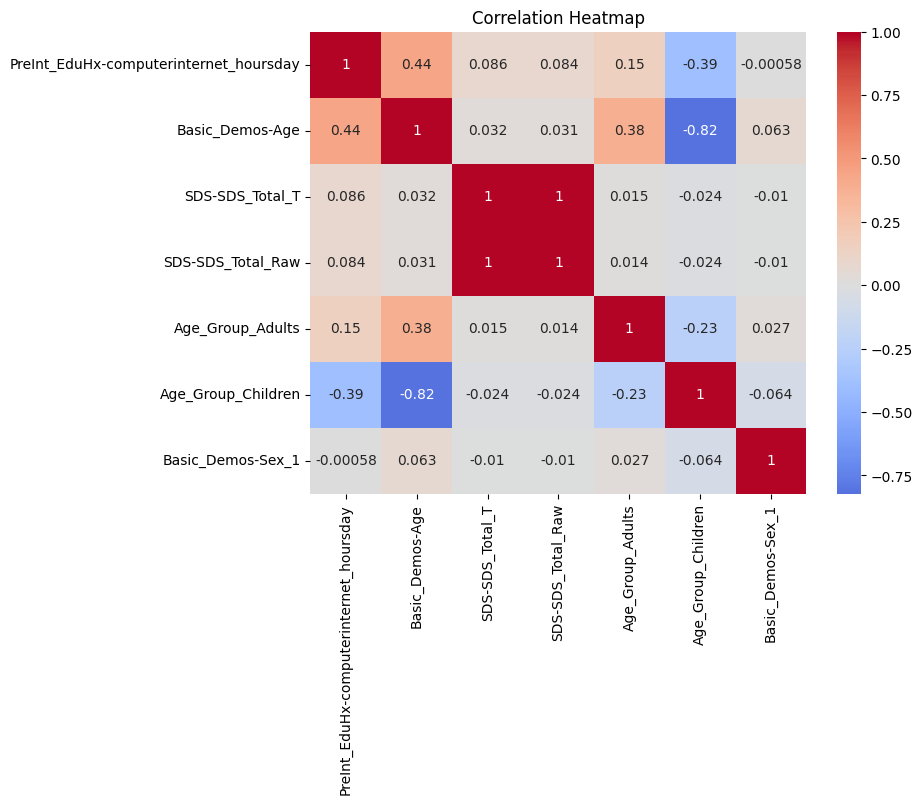

In [19]:


# Exclude rows where 'PreInt_EduHx-computerinternet_hoursday' is NaN and select relevant columns
filtered_data = train_pciatAvg[train_pciatAvg['PreInt_EduHx-computerinternet_hoursday'].notna()][['PreInt_EduHx-computerinternet_hoursday','Basic_Demos-Age', 'Basic_Demos-Sex','SDS-SDS_Total_T', 'SDS-SDS_Total_Raw']]

# Create Age_Group
filtered_data['Age_Group'] = pd.cut(filtered_data['Basic_Demos-Age'], bins=[4, 12, 18, 22], labels=['Children', 'Adolescents', 'Adults'])

# OneHotEncode both Age_Group and Basic_Demos-Sex
drop_enc = OneHotEncoder(drop='first', sparse_output=False)
categorical_cols = ['Age_Group', 'Basic_Demos-Sex']
encoded_cols = drop_enc.fit_transform(filtered_data[categorical_cols])

# Create DataFrame for the encoded columns
encoded_df = pd.DataFrame(encoded_cols, columns=drop_enc.get_feature_names_out(categorical_cols))

# Concatenate encoded columns with the original filtered_data
filtered_data = pd.concat([filtered_data.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

# Now you can drop the original categorical columns if needed
filtered_data.drop(categorical_cols, axis=1, inplace=True)

# Calculate the correlation matrix
corr_matrix = filtered_data.corr()
print(filtered_data.corr()['PreInt_EduHx-computerinternet_hoursday'])

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

##### - Imputing features

In [20]:
def imputing(df):
    # Step 1: Fill missing values in season-related categorical columns with their most frequent value (mode)
    fill_with_mode = ['CGAS-Season', 'Physical-Season', 'FGC-Season', 'SDS-Season', 'PreInt_EduHx-Season']
    for col in fill_with_mode:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mode()[0])

    # Step 2: Fill missing numeric values using the median of each column.
    df['CGAS-CGAS_Score'] = df['CGAS-CGAS_Score'].fillna(df['CGAS-CGAS_Score'].median())

    # Step 3: Groupby the columns age group and sex
    df['Age_Group'] = pd.cut(df['Basic_Demos-Age'], bins=[4, 12, 18, 22], labels=['Children', 'Adolescents', 'Adults'])
    group_cols = ['Age_Group', 'Basic_Demos-Sex']

    # Step 4: Handle missing values for height and weight 
    for col in ['Physical-Weight', 'Physical-Height']:
        # Step 4a: Fill using median grouped by age group and gender
        df[col] = df.groupby(group_cols)[col].transform(lambda x: x.fillna(x.median()))

        # Step 4b: Fill remaining missing values using median grouped by age group
        missing_vals_mask = df[col].isna()  
        df.loc[missing_vals_mask, col] = df.loc[missing_vals_mask].groupby('Age_Group')[col].transform(lambda x: x.fillna(x.median()))

        # Step 4c: Fill any remaining missing values using overall median
        df.loc[df[col].isna(), col] = df[col].median()  


    # Step 5: Compute BMI using available height and weight data (converted to metric units)

    
        df['Physical-Weight'] = df['Physical-Weight'] * 0.453592
        df['Physical-Height'] = df['Physical-Height'] * 0.0254

    df.loc[df['Physical-BMI'].isna(), 'Physical-BMI'] = df.apply(
        lambda row: row['Physical-Weight'] / (row['Physical-Height'] ** 2), axis=1
    )

    # Step 6: Fill missing physical features such as blood pressure and heart rate
    phys_cols = ['Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP']
    for col in phys_cols:
        # Step 6a: Impute using median within age group and gender
        df[col] = df.groupby(group_cols)[col].transform(lambda x: x.fillna(x.median()))

        # Step 6b: Fill remaining values based on age group median
        missing_vals_mask = df[col].isna()  # Create a mask for NaN values
        df.loc[missing_vals_mask, col] = df.loc[missing_vals_mask].groupby('Age_Group')[col].transform(lambda x: x.fillna(x.median()))

        # Step 6c:  Final fallback to overall column median
        df[col] = df[col].fillna(df[col].median())

   # Step 7: Fill missing fitness assessment scores using grouped medians
    fitness_cols = [i for i in train_pciatAvg.columns if 'FGC' in i and i !='FGC-Season']
    for col in fitness_cols:
        df[col] = df.groupby(group_cols)[col].transform(lambda x: x.fillna(x.median()))
        df[col] = df[col].fillna(df[col].median())

     # Step 8: Impute sleep quality scores 
    group_cols_sleep = ['Age_Group', 'Basic_Demos-Sex', 'CGAS-Season', 'Physical-Season',
                  'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP'] + fitness_cols

    for col in ['SDS-SDS_Total_Raw', 'SDS-SDS_Total_T']:
        # Only calculate for rows where the current column value is missing
        missing_vals_mask = df[col].isna() 

        # Impute based on all relevant groups including SII for missing values
        df.loc[missing_vals_mask, col] = df.loc[missing_vals_mask].groupby(group_cols_sleep)[col].transform(lambda x: x.fillna(x.median()))

        # fallback incase of some condition mismatch
        missing_vals_mask = df[col].isna()
        df.loc[missing_vals_mask, col] = df.loc[missing_vals_mask].groupby('Age_Group')[col].transform(lambda x: x.fillna(x.median()))
        df[col] = df[col].fillna(df[col].median())

    # Step 9: Impute internet usage time by grouping based on age group
    df['PreInt_EduHx-computerinternet_hoursday'] = df.apply(
        lambda row: row['PreInt_EduHx-computerinternet_hoursday'] if not pd.isna(row['PreInt_EduHx-computerinternet_hoursday']) else
        df.groupby(['Age_Group'])['PreInt_EduHx-computerinternet_hoursday'].median().get(
            (row['Age_Group']), np.nan), axis=1)

    # Step 10: Fill remaining missing internet usage values with overall median
    df['PreInt_EduHx-computerinternet_hoursday'].fillna(df['PreInt_EduHx-computerinternet_hoursday'].median(), inplace=True)

    return df

train_pciatAvg=imputing(train_pciatAvg)
test=imputing(test)

In [21]:
train_pciatAvg.isna().sum()

Basic_Demos-Enroll_Season                 0
Basic_Demos-Age                           0
Basic_Demos-Sex                           0
CGAS-Season                               0
CGAS-CGAS_Score                           0
Physical-Season                           0
Physical-BMI                              0
Physical-Height                           0
Physical-Weight                           0
Physical-Diastolic_BP                     0
Physical-HeartRate                        0
Physical-Systolic_BP                      0
FGC-Season                                0
FGC-FGC_CU                                0
FGC-FGC_CU_Zone                           0
FGC-FGC_PU                                0
FGC-FGC_PU_Zone                           0
FGC-FGC_SRL                               0
FGC-FGC_SRL_Zone                          0
FGC-FGC_SRR                               0
FGC-FGC_SRR_Zone                          0
FGC-FGC_TL                                0
FGC-FGC_TL_Zone                 

In [22]:
test.isna().sum()

Basic_Demos-Enroll_Season                 0
Basic_Demos-Age                           0
Basic_Demos-Sex                           0
CGAS-Season                               0
CGAS-CGAS_Score                           0
Physical-Season                           0
Physical-BMI                              0
Physical-Height                           0
Physical-Weight                           0
Physical-Diastolic_BP                     0
Physical-HeartRate                        0
Physical-Systolic_BP                      0
FGC-Season                                0
FGC-FGC_CU                                0
FGC-FGC_CU_Zone                           0
FGC-FGC_PU                                0
FGC-FGC_PU_Zone                           0
FGC-FGC_SRL                               0
FGC-FGC_SRL_Zone                          0
FGC-FGC_SRR                               0
FGC-FGC_SRR_Zone                          0
FGC-FGC_TL                                0
FGC-FGC_TL_Zone                 

In [23]:
train_pciatAvg=train_pciatAvg.drop(['Pciat_total_avg','Basic_Demos-Age'],axis=1)
test=test.drop('Basic_Demos-Age',axis=1)

In [24]:
train_pciatAvg.shape,test.shape

((3960, 29), (20, 28))

#################### - Missing values settled - ##########################

### Encoding categorical values

In [25]:
train_pciatAvg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 29 columns):
 #   Column                                  Non-Null Count  Dtype   
---  ------                                  --------------  -----   
 0   Basic_Demos-Enroll_Season               3960 non-null   object  
 1   Basic_Demos-Sex                         3960 non-null   int64   
 2   CGAS-Season                             3960 non-null   object  
 3   CGAS-CGAS_Score                         3960 non-null   float64 
 4   Physical-Season                         3960 non-null   object  
 5   Physical-BMI                            3960 non-null   float64 
 6   Physical-Height                         3960 non-null   float64 
 7   Physical-Weight                         3960 non-null   float64 
 8   Physical-Diastolic_BP                   3960 non-null   float64 
 9   Physical-HeartRate                      3960 non-null   float64 
 10  Physical-Systolic_BP                    3960 non

In [26]:
train_pciatAvg['Age_Group'].unique()

['Children', 'Adolescents', 'Adults']
Categories (3, object): ['Children' < 'Adolescents' < 'Adults']

**Encoding Age_Group**

In [27]:
train_pciatAvg['Age_Group']=train_pciatAvg['Age_Group'].map({'Children':0,'Adolescents':1,'Adults':2}).astype(np.int32)
test['Age_Group']=test['Age_Group'].map({'Children':0,'Adolescents':1,'Adults':2}).astype(np.int32)

In [28]:
train_pciatAvg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 29 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Basic_Demos-Enroll_Season               3960 non-null   object 
 1   Basic_Demos-Sex                         3960 non-null   int64  
 2   CGAS-Season                             3960 non-null   object 
 3   CGAS-CGAS_Score                         3960 non-null   float64
 4   Physical-Season                         3960 non-null   object 
 5   Physical-BMI                            3960 non-null   float64
 6   Physical-Height                         3960 non-null   float64
 7   Physical-Weight                         3960 non-null   float64
 8   Physical-Diastolic_BP                   3960 non-null   float64
 9   Physical-HeartRate                      3960 non-null   float64
 10  Physical-Systolic_BP                    3960 non-null   floa

In [29]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 28 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Basic_Demos-Enroll_Season               20 non-null     object 
 1   Basic_Demos-Sex                         20 non-null     int64  
 2   CGAS-Season                             20 non-null     object 
 3   CGAS-CGAS_Score                         20 non-null     float64
 4   Physical-Season                         20 non-null     object 
 5   Physical-BMI                            20 non-null     float64
 6   Physical-Height                         20 non-null     float64
 7   Physical-Weight                         20 non-null     float64
 8   Physical-Diastolic_BP                   20 non-null     float64
 9   Physical-HeartRate                      20 non-null     float64
 10  Physical-Systolic_BP                    20 non-null     float64


In [30]:
season_cols=[col for col in train_pciatAvg.columns if 'Season' in col]

**Encoding all season features**

In [31]:
season_cols

['Basic_Demos-Enroll_Season',
 'CGAS-Season',
 'Physical-Season',
 'FGC-Season',
 'SDS-Season',
 'PreInt_EduHx-Season']

In [32]:
train_pciatAvg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 29 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Basic_Demos-Enroll_Season               3960 non-null   object 
 1   Basic_Demos-Sex                         3960 non-null   int64  
 2   CGAS-Season                             3960 non-null   object 
 3   CGAS-CGAS_Score                         3960 non-null   float64
 4   Physical-Season                         3960 non-null   object 
 5   Physical-BMI                            3960 non-null   float64
 6   Physical-Height                         3960 non-null   float64
 7   Physical-Weight                         3960 non-null   float64
 8   Physical-Diastolic_BP                   3960 non-null   float64
 9   Physical-HeartRate                      3960 non-null   float64
 10  Physical-Systolic_BP                    3960 non-null   floa

In [33]:
train_pciatAvg.columns.tolist()

['Basic_Demos-Enroll_Season',
 'Basic_Demos-Sex',
 'CGAS-Season',
 'CGAS-CGAS_Score',
 'Physical-Season',
 'Physical-BMI',
 'Physical-Height',
 'Physical-Weight',
 'Physical-Diastolic_BP',
 'Physical-HeartRate',
 'Physical-Systolic_BP',
 'FGC-Season',
 'FGC-FGC_CU',
 'FGC-FGC_CU_Zone',
 'FGC-FGC_PU',
 'FGC-FGC_PU_Zone',
 'FGC-FGC_SRL',
 'FGC-FGC_SRL_Zone',
 'FGC-FGC_SRR',
 'FGC-FGC_SRR_Zone',
 'FGC-FGC_TL',
 'FGC-FGC_TL_Zone',
 'SDS-Season',
 'SDS-SDS_Total_Raw',
 'SDS-SDS_Total_T',
 'PreInt_EduHx-Season',
 'PreInt_EduHx-computerinternet_hoursday',
 'sii_pred',
 'Age_Group']

### Model Preparation

In [34]:
X=train_pciatAvg.drop('sii_pred',axis=1)
y=train_pciatAvg['sii_pred']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [35]:
# Count class distribution in the training set
print(y_train.value_counts())

# Specifically for class 3
print("Number of class 3 samples in training set:", (y_train == 3).sum())


sii_pred
0    1084
2    1050
1     495
3      24
Name: count, dtype: int64
Number of class 3 samples in training set: 24


In [36]:
transformer=ColumnTransformer(transformers=
[('trn1',OneHotEncoder(sparse_output=False,drop='first',handle_unknown='ignore'),season_cols)],remainder='passthrough')

In [37]:
X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)
test = transformer.transform(test)

# Converting transformed arrays back to DataFrames
X_train = pd.DataFrame(X_train, columns=transformer.get_feature_names_out())
X_test = pd.DataFrame(X_test, columns=transformer.get_feature_names_out())
test = pd.DataFrame(test, columns=transformer.get_feature_names_out())

##### - Scaling features 

In [38]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
test= scaler.transform(test)

##### - Defining Evaluation metric

In [39]:
def quadratic_weighted_kappa(y_true, y_pred, n_classes=4):
    O = confusion_matrix(y_true, y_pred)
    W = np.zeros((n_classes, n_classes))

    for i in range(n_classes):
        for j in range(n_classes):
            W[i, j] = (i - j) ** 2 / (n_classes - 1) ** 2

    E = np.outer(np.sum(O, axis=1), np.sum(O, axis=0)) / np.sum(O)

    num = np.sum(W * O)
    denom = np.sum(W * E)

    kappa = 1 - (num / denom)
    return kappa

In [40]:
df = train_pciatAvg.copy()
target = "sii_pred"   


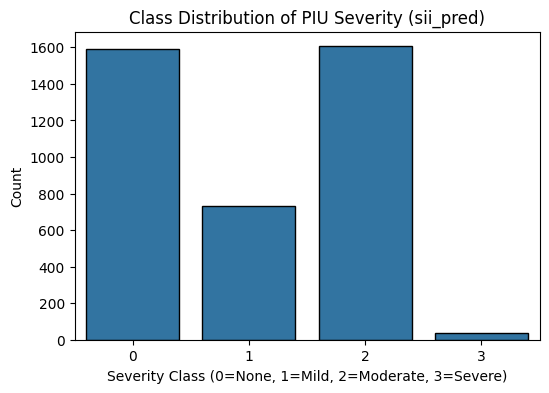

In [41]:


plt.figure(figsize=(6,4))
sns.countplot(data=df, x="sii_pred", edgecolor="black")
plt.title("Class Distribution of PIU Severity (sii_pred)")
plt.xlabel("Severity Class (0=None, 1=Mild, 2=Moderate, 3=Severe)")
plt.ylabel("Count")
plt.show()

In [42]:
class_perc = df["sii_pred"].value_counts(normalize=True) * 100
print("Class distribution in percentages:\n")
print(class_perc.round(2))


Class distribution in percentages:

sii_pred
2    40.53
0    40.15
1    18.41
3     0.91
Name: proportion, dtype: float64


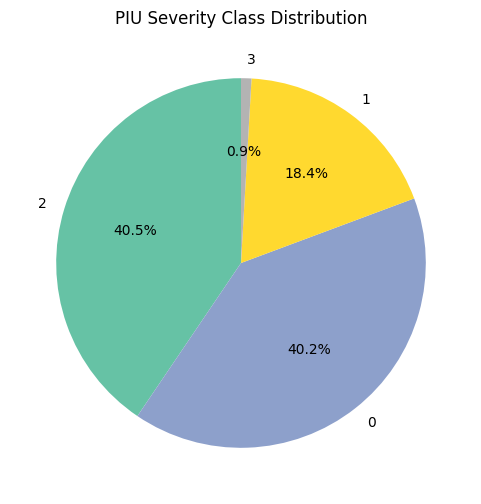

In [43]:
plt.figure(figsize=(6,6))
df["sii_pred"].value_counts().plot(
    kind="pie", autopct='%1.1f%%', startangle=90, cmap="Set2", ylabel=""
)
plt.title("PIU Severity Class Distribution")
plt.show()


In [44]:
def qwk(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights="quadratic")

qwk_scorer = make_scorer(qwk)

# Pick a safe k_neighbors based on smallest class in TRAIN ONLY
counts = Counter(y_train)
minority_count = min(counts.values())
k_safe = max(1, min(5, minority_count - 1))  # ensure k ≤ minority_count-1

def make_smote():
    return SMOTE(random_state=42, k_neighbors=k_safe, sampling_strategy="not_majority")


## Model Training & Evaluation

In [45]:


def qwk(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights="quadratic")
qwk_scorer = make_scorer(qwk)

# Find safe k_neighbors for SMOTE based on your training set
counts = Counter(y_train)
minority_count = min(counts.values())
k_safe = max(1, min(5, minority_count - 1))  # avoid errors if class 3 is tiny

def make_smote():
    return SMOTE(random_state=42, k_neighbors=k_safe, sampling_strategy="not majority")


# Define models wrapped in a pipeline with SMOTE
models = {
    'Decision Tree': Pipeline([('smote', make_smote()), ('clf', DecisionTreeClassifier())]),
    'Random Forest': Pipeline([('smote', make_smote()), ('clf', RandomForestClassifier(random_state=42))]),
    'XGBoost': Pipeline([('smote', make_smote()), ('clf', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))]),
    'LightGBM': Pipeline([('smote', make_smote()), ('clf', LGBMClassifier(verbose=-1, random_state=42))]),
    'CatBoost': Pipeline([('smote', make_smote()), ('clf', CatBoostClassifier(silent=True, random_state=42))])
}

# Run cross-validation
results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, pipe in models.items():
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring=qwk_scorer, n_jobs=-1)
    results[name] = np.mean(scores)

# Print results
for model_name, score in results.items():
    print(f"{model_name}: Average QWK (with SMOTE) = {score:.4f}")

Decision Tree: Average QWK (with SMOTE) = 0.5296
Random Forest: Average QWK (with SMOTE) = 0.6662
XGBoost: Average QWK (with SMOTE) = 0.6431
LightGBM: Average QWK (with SMOTE) = 0.6645
CatBoost: Average QWK (with SMOTE) = 0.6617


### Doing Hyperparameter tuning for all except DT

In [46]:
# ==== FULL HYPERPARAMETER TUNING (SMOTE + Stratified CV + QWK) ====



# ---------- Scorer ----------
def qwk(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights="quadratic")
qwk_scorer = make_scorer(qwk)

# ---------- SMOTE helpers ----------
counts = Counter(y_train)
minority_count = min(counts.values())
k_safe = max(1, min(5, minority_count - 1))  # ensure k ≤ minority_count-1

def make_smote_all():
    return SMOTE(random_state=42, k_neighbors=k_safe, sampling_strategy="not majority")

def make_smote_cat():
    # lighter/faster during CatBoost tuning
    return SMOTE(random_state=42, k_neighbors=1, sampling_strategy="minority")

# ---------- CV splitters ----------
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # RF/XGB/LGB
cv3 = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # CatBoost faster

# ---------- Class count ----------
n_classes = len(np.unique(y_train))

# ---------- Optuna objectives ----------
def objective_rf(trial):
    params = {
        "n_estimators":      trial.suggest_int("n_estimators", 100, 500),
        "max_depth":         trial.suggest_int("max_depth", 5, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf":  trial.suggest_int("min_samples_leaf", 1, 10),
        "random_state": 42,
        "n_jobs": -1,
    }
    pipe = Pipeline([
        ("smote", make_smote_all()),
        ("rf", RandomForestClassifier(**params))
    ])
    scores = cross_val_score(pipe, X_train, y_train, cv=cv5, scoring=qwk_scorer, n_jobs=-1)
    return float(scores.mean())

def objective_xgb(trial):
    params = {
        "n_estimators":      trial.suggest_int("n_estimators", 200, 800),
        "max_depth":         trial.suggest_int("max_depth", 3, 12),
        "learning_rate":     trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample":         trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree":  trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight":  trial.suggest_int("min_child_weight", 1, 10),
        "gamma":             trial.suggest_float("gamma", 0.0, 5.0),
        "objective": "multi:softprob" if n_classes > 2 else "binary:logistic",
        "num_class": n_classes if n_classes > 2 else None,
        "eval_metric": "mlogloss",
        "use_label_encoder": False,
        "random_state": 42,
    }
    params = {k: v for k, v in params.items() if v is not None}
    pipe = Pipeline([
        ("smote", make_smote_all()),
        ("xgb", XGBClassifier(**params))
    ])
    scores = cross_val_score(pipe, X_train, y_train, cv=cv5, scoring=qwk_scorer, n_jobs=-1)
    return float(scores.mean())

def objective_lgb(trial):
    params = {
        "n_estimators":       trial.suggest_int("n_estimators", 200, 1000),
        "max_depth":          trial.suggest_int("max_depth", -1, 20),
        "learning_rate":      trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "num_leaves":         trial.suggest_int("num_leaves", 31, 255),
        "subsample":          trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree":   trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_samples":  trial.suggest_int("min_child_samples", 10, 100),
        "objective": "multiclass" if n_classes > 2 else "binary",
        "num_class": n_classes if n_classes > 2 else None,
        "verbose": -1,
        "random_state": 42,
    }
    params = {k: v for k, v in params.items() if v is not None}
    pipe = Pipeline([
        ("smote", make_smote_all()),
        ("lgb", LGBMClassifier(**params))
    ])
    scores = cross_val_score(pipe, X_train, y_train, cv=cv5, scoring=qwk_scorer, n_jobs=-1)
    return float(scores.mean())

# FAST CatBoost objective (3-fold CV + smaller search + lighter SMOTE)
def objective_catboost_fast(trial):
    params = {
        "iterations":    trial.suggest_int("iterations", 100, 350),
        "depth":         trial.suggest_int("depth", 4, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.2, log=True),
        "l2_leaf_reg":   trial.suggest_float("l2_leaf_reg", 1.0, 6.0),
        "loss_function": "MultiClass" if n_classes > 2 else "Logloss",
        "random_state":  42,
        "thread_count":  -1,
      
    }
    pipe = Pipeline([
        ("smote", make_smote_cat()),  # lighter/faster for Cat tuning
        ("cat", CatBoostClassifier(**params, verbose=0))
    ])
    scores = cross_val_score(pipe, X_train, y_train, cv=cv3, scoring=qwk_scorer, n_jobs=-1)
    return float(scores.mean())


optuna.logging.set_verbosity(optuna.logging.WARNING)
studies = {}

for name, obj, trials in [
    ("RandomForest", objective_rf,            50),
    ("XGBoost",      objective_xgb,           50),
    ("LightGBM",     objective_lgb,           50),
    ("CatBoost",     objective_catboost_fast, 50),  
]:
    print(f"== Tuning {name} ==")
    study = optuna.create_study(direction="maximize",
                                sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(obj, n_trials=trials, show_progress_bar=True)
    studies[name] = study
    print(f"{name} best QWK:   {study.best_value:.4f}")
    print(f"{name} best params: {study.best_params}\n")

# ---------- Summary ----------
rows = []
for name, study in studies.items():
    rows.append([name, study.best_value, study.best_params])
summary = pd.DataFrame(rows, columns=["Model", "Best QWK (CV mean)", "Best Params"])\
            .sort_values("Best QWK (CV mean)", ascending=False)
summary


== Tuning RandomForest ==


  0%|          | 0/50 [00:00<?, ?it/s]

RandomForest best QWK:   0.6731
RandomForest best params: {'n_estimators': 471, 'max_depth': 18, 'min_samples_split': 11, 'min_samples_leaf': 1}

== Tuning XGBoost ==


  0%|          | 0/50 [00:00<?, ?it/s]

XGBoost best QWK:   0.6860
XGBoost best params: {'n_estimators': 584, 'max_depth': 8, 'learning_rate': 0.018729504211759163, 'subsample': 0.9205560078591839, 'colsample_bytree': 0.8765750666559773, 'min_child_weight': 8, 'gamma': 1.4255498097264314}

== Tuning LightGBM ==


  0%|          | 0/50 [00:00<?, ?it/s]

LightGBM best QWK:   0.6816
LightGBM best params: {'n_estimators': 322, 'max_depth': 7, 'learning_rate': 0.0155469173557522, 'num_leaves': 116, 'subsample': 0.795795163509494, 'colsample_bytree': 0.8096183749033754, 'min_child_samples': 64}

== Tuning CatBoost ==


  0%|          | 0/50 [00:00<?, ?it/s]

CatBoost best QWK:   0.6761
CatBoost best params: {'iterations': 287, 'depth': 8, 'learning_rate': 0.0915774247022403, 'l2_leaf_reg': 3.3686238150943164}



,Model,Best QWK (CV mean),Best Params
1,XGBoost,0.686029,"{'n_estimators': 584, 'max_depth': 8, 'learnin..."
2,LightGBM,0.681552,"{'n_estimators': 322, 'max_depth': 7, 'learnin..."
3,CatBoost,0.676053,"{'iterations': 287, 'depth': 8, 'learning_rate..."
0,RandomForest,0.673053,"{'n_estimators': 471, 'max_depth': 18, 'min_sa..."


In [47]:
best_rf_params = studies['RandomForest'].best_params
print("Best Random Forest params:", best_rf_params)


Best Random Forest params: {'n_estimators': 471, 'max_depth': 18, 'min_samples_split': 11, 'min_samples_leaf': 1}


In [48]:
best_XGBoost_params = studies['XGBoost'].best_params
print("Best XGBoost params:", best_XGBoost_params)



Best XGBoost params: {'n_estimators': 584, 'max_depth': 8, 'learning_rate': 0.018729504211759163, 'subsample': 0.9205560078591839, 'colsample_bytree': 0.8765750666559773, 'min_child_weight': 8, 'gamma': 1.4255498097264314}


In [49]:
best_LightGBM_params = studies['LightGBM'].best_params
print("Best LightGBM params:", best_LightGBM_params)



Best LightGBM params: {'n_estimators': 322, 'max_depth': 7, 'learning_rate': 0.0155469173557522, 'num_leaves': 116, 'subsample': 0.795795163509494, 'colsample_bytree': 0.8096183749033754, 'min_child_samples': 64}


In [50]:

best_CatBoost_params = studies['CatBoost'].best_params
print("Best CatBoost params:", best_CatBoost_params)

Best CatBoost params: {'iterations': 287, 'depth': 8, 'learning_rate': 0.0915774247022403, 'l2_leaf_reg': 3.3686238150943164}


### Stacked ensemble approach (meta_model= RF)

In [51]:
# ==== Leak-free Stacking with SMOTE inside each base learner ====


# 1) QWK scorer
def qwk(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights="quadratic")
qwk_scorer = make_scorer(qwk)


counts = Counter(y_train)
minority_count = min(counts.values())
k_safe = max(1, min(5, minority_count - 1))  # ensure k ≤ minority_count-1

def make_smote():
    return SMOTE(random_state=42, k_neighbors=k_safe, sampling_strategy="not majority")

# 3) Wrap each tuned base model in a Pipeline: SMOTE -> Model
rf_base  = Pipeline([("smote", make_smote()),
                     ("clf",  RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1))])

xgb_base = Pipeline([("smote", make_smote()),
                     ("clf", XGBClassifier(**best_XGBoost_params,
                                           use_label_encoder=False,
                                           eval_metric="mlogloss",
                                           random_state=42))])

lgb_base = Pipeline([("smote", make_smote()),
                     ("clf", LGBMClassifier(**best_LightGBM_params,
                                            verbose=-1,
                                            random_state=42))])

cat_base = Pipeline([("smote", make_smote()),
                     ("clf", CatBoostClassifier(**best_CatBoost_params,
                                               silent=True,
                                               random_state=42))])

base_models = [
    ("rf",  rf_base),
    ("xgb", xgb_base),
    ("lgb", lgb_base),
    ("cat", cat_base),
]

# 4) Meta-model: no SMOTE here (it learns from OOF predictions of bases)
meta_model = RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1)

# 5) Stacking ensemble (internal CV builds meta-features correctly)
stacked_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,                 # internal CV to generate OOF predictions for meta-model
    n_jobs=-1,
    stack_method="auto",
    passthrough=False
)

# 6) Outer CV to estimate performance
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(stacked_model, X_train, y_train,
                            cv=cv_outer, scoring=qwk_scorer, n_jobs=-1)

print(f"Stacked Model: Average QWK (5-fold CV) = {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")


Stacked Model: Average QWK (5-fold CV) = 0.6671 ± 0.0293


In [52]:


counts = Counter(y_train)
minority_count = min(counts.values())
k_safe = max(1, min(5, minority_count - 1)) 

def make_smote():
   
    return SMOTE(random_state=42, k_neighbors=k_safe, sampling_strategy="not majority")

# 3) Wrap each tuned base model in a Pipeline: SMOTE -> Model
rf_base  = Pipeline([("smote", make_smote()),
                     ("clf",  RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1))])

xgb_base = Pipeline([("smote", make_smote()),
                     ("clf", XGBClassifier(**best_XGBoost_params,
                                           use_label_encoder=False,
                                           eval_metric="mlogloss",
                                           random_state=42))])

lgb_base = Pipeline([("smote", make_smote()),
                     ("clf", LGBMClassifier(**best_LightGBM_params,
                                            verbose=-1,
                                            random_state=42))])

cat_base = Pipeline([("smote", make_smote()),
                     ("clf", CatBoostClassifier(**best_CatBoost_params,
                                               silent=True,
                                               random_state=42))])

base_models = [
    ("rf",  rf_base),
    ("xgb", xgb_base),
    ("lgb", lgb_base),
    ("cat", cat_base),
]

# 4) Meta-model: no SMOTE here (it learns from OOF predictions of bases)
meta_model = XGBClassifier(**best_XGBoost_params, use_label_encoder=False, eval_metric="mlogloss", random_state=42)

# 5) Stacking ensemble (internal CV builds meta-features correctly)
stacked_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,                 # internal CV to generate OOF predictions for meta-model
    n_jobs=-1,
    stack_method="auto",
    passthrough=False
)

# 6) Outer CV to estimate performance
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(stacked_model, X_train, y_train,
                            cv=cv_outer, scoring=qwk_scorer, n_jobs=-1)

print(f"Stacked Model: Average QWK (5-fold CV) = {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")


Stacked Model: Average QWK (5-fold CV) = 0.6692 ± 0.0281


In [53]:



counts = Counter(y_train)
minority_count = min(counts.values())
k_safe = max(1, min(5, minority_count - 1)) 

def make_smote():

    return SMOTE(random_state=42, k_neighbors=k_safe, sampling_strategy="not majority")

# 3) Wrap each tuned base model in a Pipeline: SMOTE -> Model
rf_base  = Pipeline([("smote", make_smote()),
                     ("clf",  RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1))])

xgb_base = Pipeline([("smote", make_smote()),
                     ("clf", XGBClassifier(**best_XGBoost_params,
                                           use_label_encoder=False,
                                           eval_metric="mlogloss",
                                           random_state=42))])

lgb_base = Pipeline([("smote", make_smote()),
                     ("clf", LGBMClassifier(**best_LightGBM_params,
                                            verbose=-1,
                                            random_state=42))])

cat_base = Pipeline([("smote", make_smote()),
                     ("clf", CatBoostClassifier(**best_CatBoost_params,
                                               silent=True,
                                               random_state=42))])

base_models = [
    ("rf",  rf_base),
    ("xgb", xgb_base),
    ("lgb", lgb_base),
    ("cat", cat_base),
]

# 4) Meta-model: no SMOTE here (it learns from OOF predictions of bases)
meta_model = LGBMClassifier(**best_LightGBM_params, verbose=-1, random_state=42)

# 5) Stacking ensemble (internal CV builds meta-features correctly)
stacked_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,                 # internal CV to generate OOF predictions for meta-model
    n_jobs=-1,
    stack_method="auto",
    passthrough=False
)

# 6) Outer CV to estimate performance
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(stacked_model, X_train, y_train,
                            cv=cv_outer, scoring=qwk_scorer, n_jobs=-1)

print(f"Stacked Model: Average QWK (5-fold CV) = {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")


Stacked Model: Average QWK (5-fold CV) = 0.6541 ± 0.0303


In [54]:


counts = Counter(y_train)
minority_count = min(counts.values())
k_safe = max(1, min(5, minority_count - 1))  # ensure k ≤ minority_count-

def make_smote():
    return SMOTE(random_state=42, k_neighbors=k_safe, sampling_strategy="not majority")

# 3) Wrap each tuned base model in a Pipeline: SMOTE -> Model
rf_base  = Pipeline([("smote", make_smote()),
                     ("clf",  RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1))])

xgb_base = Pipeline([("smote", make_smote()),
                     ("clf", XGBClassifier(**best_XGBoost_params,
                                           use_label_encoder=False,
                                           eval_metric="mlogloss",
                                           random_state=42))])

lgb_base = Pipeline([("smote", make_smote()),
                     ("clf", LGBMClassifier(**best_LightGBM_params,
                                            verbose=-1,
                                            random_state=42))])

cat_base = Pipeline([("smote", make_smote()),
                     ("clf", CatBoostClassifier(**best_CatBoost_params,
                                               silent=True,
                                               random_state=42))])

base_models = [
    ("rf",  rf_base),
    ("xgb", xgb_base),
    ("lgb", lgb_base),
    ("cat", cat_base),
]

# 4) Meta-model: no SMOTE here (it learns from OOF predictions of bases)
meta_model = CatBoostClassifier(**best_CatBoost_params, silent=True, random_state=42)


# 5) Stacking ensemble (internal CV builds meta-features correctly)
stacked_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,                 # internal CV to generate OOF predictions for meta-model
    n_jobs=-1,
    stack_method="auto",
    passthrough=False
)

# 6) Outer CV to estimate performance
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(stacked_model, X_train, y_train,
                            cv=cv_outer, scoring=qwk_scorer, n_jobs=-1)

print(f"Stacked Model: Average QWK (5-fold CV) = {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")


Stacked Model: Average QWK (5-fold CV) = 0.6645 ± 0.0347


##### Selecting RF for final prediction as it is the best performing model.

In [55]:
sample = pd.read_csv('C:/MY_Masters_Project/child-mind-institute-problematic-internet-use/sample_submission.csv')


# Train the Random Forest model with the best hyperparameters
rf_model = RandomForestClassifier(**best_rf_params,class_weight="balanced", random_state=42)
rf_model.fit(X_train, y_train)

predictions = rf_model.predict(test)
submission = pd.DataFrame({
    'id': sample['id'],
    'sii': predictions
})
submission.to_csv('submission.csv', index=False)

print("Submission file created: submission.csv")

Submission file created: submission.csv


#### Model Evaluation

In [56]:

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())

rf_model = RandomForestClassifier(**best_rf_params, random_state=42)
rf_model.fit(X_train_res, y_train_res)


Before SMOTE: sii_pred
0    1084
2    1050
1     495
3      24
Name: count, dtype: int64
After SMOTE: sii_pred
0    1084
2    1084
1    1084
3    1084
Name: count, dtype: int64


,n_estimators,471
,criterion,'gini'
,max_depth,18
,min_samples_split,11
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [57]:
# Train tuned model
rf_model = RandomForestClassifier(**best_rf_params,class_weight="balanced", random_state=42)
rf_model.fit(X_train_res, y_train_res)

# Evaluate tuned model on held-out test
y_pred = rf_model.predict(X_test)


# Make a DataFrame to compare side by side
comparison = pd.DataFrame({
    "True_Label": y_test.values,
    "Predicted_Label": y_pred
})


# Optional: how many are correct vs wrong
comparison["Correct"] = comparison["True_Label"] == comparison["Predicted_Label"]
print("\nCorrect predictions:", comparison["Correct"].sum())
print("Total samples:", len(comparison))
print("Accuracy:", comparison["Correct"].mean())



Correct predictions: 877
Total samples: 1307
Accuracy: 0.6710022953328233


In [58]:
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    cohen_kappa_score
)

rf_model = RandomForestClassifier(**best_rf_params,class_weight="balanced", random_state=42)
rf_model.fit(X_train_res, y_train_res)
# Predictions
y_pred = rf_model.predict(X_test)

# Overall metrics (in %)
accuracy = accuracy_score(y_test, y_pred) * 100
bal_acc = balanced_accuracy_score(y_test, y_pred) * 100
macro_f1 = f1_score(y_test, y_pred, average="macro") * 100
weighted_f1 = f1_score(y_test, y_pred, average="weighted") * 100
kappa = cohen_kappa_score(y_test, y_pred) * 100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Balanced Accuracy: {bal_acc:.2f}%")
print(f"Macro F1 Score: {macro_f1:.2f}%")
print(f"Weighted F1 Score: {weighted_f1:.2f}%")
print(f"Cohen's Kappa: {kappa:.2f}%\n")


# Detailed per-class Precision, Recall, F1
print("Per-class metrics:")
print(classification_report(y_test, y_pred, digits=4))

Accuracy: 67.10%
Balanced Accuracy: 50.96%
Macro F1 Score: 51.72%
Weighted F1 Score: 68.19%
Cohen's Kappa: 49.27%

Per-class metrics:
              precision    recall  f1-score   support

           0     0.6745    0.7411    0.7062       506
           1     0.3196    0.3974    0.3543       234
           2     0.9004    0.7333    0.8083       555
           3     0.2500    0.1667    0.2000        12

    accuracy                         0.6710      1307
   macro avg     0.5361    0.5096    0.5172      1307
weighted avg     0.7030    0.6710    0.6819      1307



### Visualization

#### Class Distribution (before and after SMOTE)

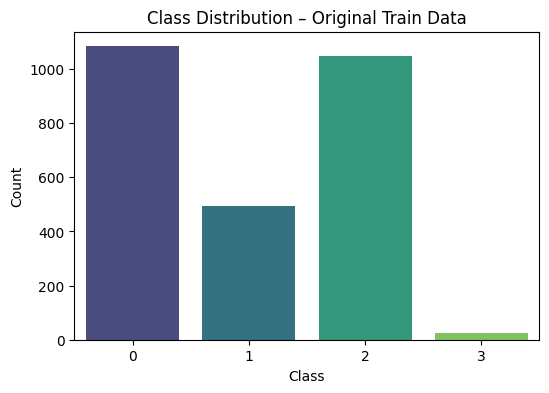

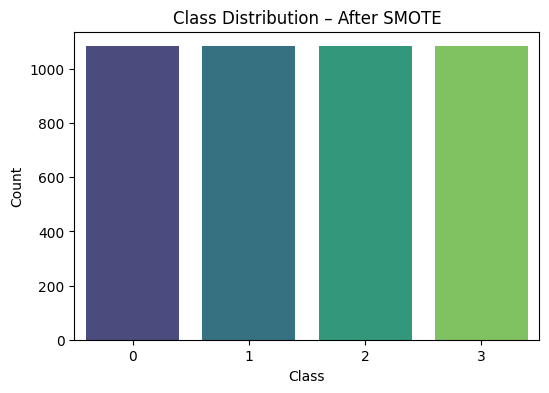

In [59]:


# Original distribution
plt.figure(figsize=(6,4))
sns.barplot(x=list(Counter(y_train).keys()), y=list(Counter(y_train).values()), palette="viridis")
plt.title("Class Distribution – Original Train Data")
plt.xlabel("Class"); plt.ylabel("Count")
plt.show()

# Distribution after SMOTE
X_res, y_res = make_smote_all().fit_resample(X_train, y_train)
plt.figure(figsize=(6,4))
sns.barplot(x=list(Counter(y_res).keys()), y=list(Counter(y_res).values()), palette="viridis")
plt.title("Class Distribution – After SMOTE")
plt.xlabel("Class"); plt.ylabel("Count")
plt.show()


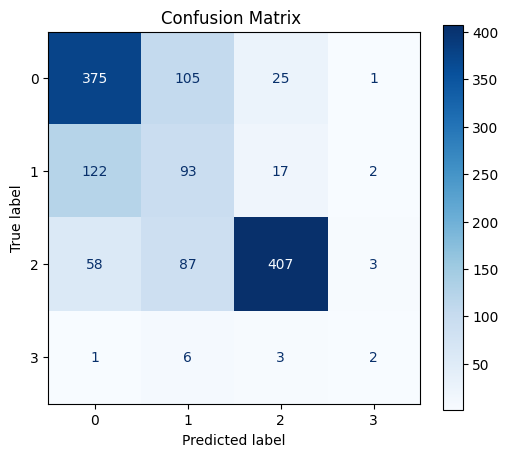

In [60]:


fig, ax = plt.subplots(figsize=(6,5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues", ax=ax)
plt.title(f"Confusion Matrix ")
plt.show()


### Multiclass ROC & PR

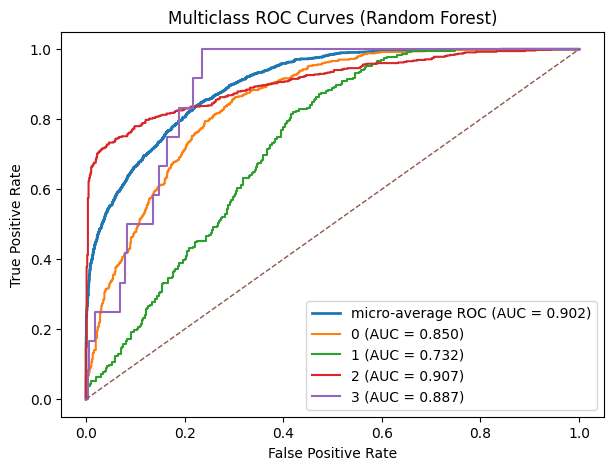

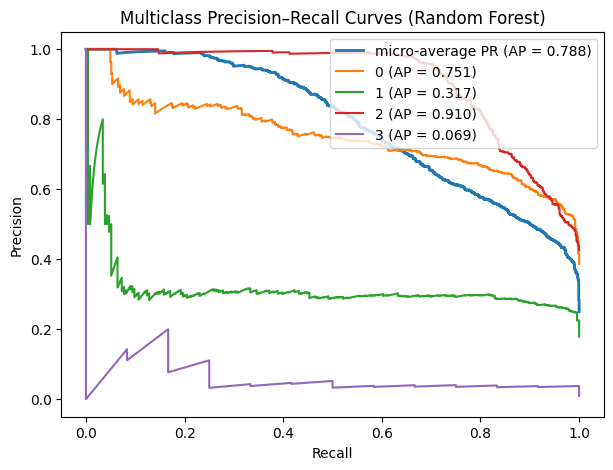

,Class,ROC AUC,Avg Precision (PR)
0,0,0.850112,0.751297
1,1,0.731932,0.317118
2,2,0.906918,0.909604
3,3,0.887194,0.069082
4,micro-average,0.901866,0.787697
5,macro-average,0.844039,0.511775


In [61]:


# 1) Get class order and probabilities from your trained Random Forest
classes = rf_model.classes_                  # ['none','mild','moderate','severe'] (example)
y_prob = rf_model.predict_proba(X_test)      # shape: (n_samples, n_classes)

# 2) Binarize true labels to One-vs-Rest
y_test_bin = label_binarize(y_test, classes=classes)  
n_classes = y_test_bin.shape[1]

# ---------------------------
# ROC CURVES
# ---------------------------
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average (aggregate)
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
roc_auc["macro"] = np.mean([roc_auc[i] for i in range(n_classes)])

plt.figure(figsize=(7,5))
plt.plot(fpr["micro"], tpr["micro"], lw=2, label=f"micro-average ROC (AUC = {roc_auc['micro']:.3f})")
for i, c in enumerate(classes):
    plt.plot(fpr[i], tpr[i], lw=1.5, label=f"{c} (AUC = {roc_auc[i]:.3f})")
plt.plot([0,1],[0,1],'--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curves (Random Forest)")
plt.legend(loc="lower right")
plt.show()

# ---------------------------
# PRECISION-RECALL CURVES
# ---------------------------
precision, recall, avg_prec = {}, {}, {}
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    avg_prec[i] = average_precision_score(y_test_bin[:, i], y_prob[:, i])

precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_bin.ravel(), y_prob.ravel())
avg_prec["micro"] = average_precision_score(y_test_bin, y_prob, average="micro")
avg_prec["macro"] = np.mean([avg_prec[i] for i in range(n_classes)])

plt.figure(figsize=(7,5))
plt.plot(recall["micro"], precision["micro"], lw=2, label=f"micro-average PR (AP = {avg_prec['micro']:.3f})")
for i, c in enumerate(classes):
    plt.plot(recall[i], precision[i], lw=1.5, label=f"{c} (AP = {avg_prec[i]:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Multiclass Precision–Recall Curves (Random Forest)")
plt.legend(loc="upper right")
plt.show()

# ---------------------------
# Compact summary table
# ---------------------------

summary_rows = []
for i, c in enumerate(classes):
    summary_rows.append({"Class": c, "ROC AUC": roc_auc[i], "Avg Precision (PR)": avg_prec[i]})
summary_rows.append({"Class": "micro-average", "ROC AUC": roc_auc["micro"], "Avg Precision (PR)": avg_prec["micro"]})
summary_rows.append({"Class": "macro-average", "ROC AUC": roc_auc["macro"], "Avg Precision (PR)": avg_prec["macro"]})
pd.DataFrame(summary_rows)


The Random Forest model achieved a high ROC AUC for the severe PIU class (0.887), indicating strong ranking ability across thresholds. However, precision and recall for this class were comparatively low, reflecting difficulty in consistently identifying severe cases at a fixed threshold due to the limited number of training examples. This discrepancy highlights the effect of class imbalance: ROC AUC may appear optimistic with rare classes, whereas precision–recall metrics provide a more realistic view of predictive reliability in practice.

### Compare metrics

,Model,Accuracy,F1_weighted,ROC_AUC_micro,ROC_AUC_macro,PR_AP_micro,PR_AP_macro,QWK
1,Random Forest,0.671,0.677,0.899,0.827,0.778,0.496,0.666
4,CatBoost,0.667,0.669,0.900,0.838,0.779,0.504,0.665
3,LightGBM,0.671,0.668,0.898,0.833,0.779,0.498,0.657
2,XGBoost,0.656,0.651,0.893,0.831,0.768,0.489,0.637
0,Decision Tree,0.598,0.605,0.732,0.641,0.458,0.355,0.523


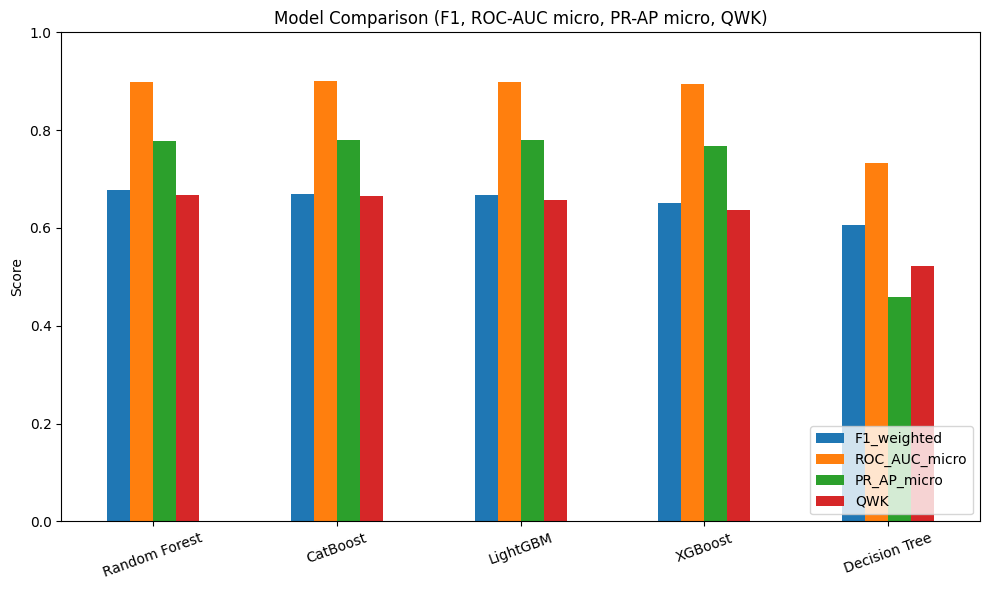

In [62]:


from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, average_precision_score,
    cohen_kappa_score
)
from sklearn.preprocessing import label_binarize



results = []
model_objs = {}

for name, pipe in models.items():
    # Fit on training split (SMOTE will only apply to training data inside the pipeline)
    pipe.fit(X_train, y_train)
    model_objs[name] = pipe

    # Predictions & probabilities
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)  # shape: (n_samples, n_classes)

    # Classes (ensure consistent ordering)
    classes = pipe.named_steps['clf'].classes_

    # Core metrics
    acc = accuracy_score(y_test, y_pred)
    f1w = f1_score(y_test, y_pred, average='weighted')

    # ROC AUC (micro/macro) — OVR across classes
    roc_micro = roc_auc_score(y_test, y_prob, labels=classes, multi_class='ovr', average='micro')
    roc_macro = roc_auc_score(y_test, y_prob, labels=classes, multi_class='ovr', average='macro')

    # PR Average Precision (micro/macro)
    y_test_bin = label_binarize(y_test, classes=classes)
    ap_micro = average_precision_score(y_test_bin, y_prob, average='micro')
    ap_macro = average_precision_score(y_test_bin, y_prob, average='macro')

    # Quadratic Weighted Kappa (QWK)
    try:
        qwk = cohen_kappa_score(y_test, y_pred, weights='quadratic')
    except TypeError:
        # older sklearn fallback (no weights arg) — remove if your version supports 'weights'
        qwk = cohen_kappa_score(y_test, y_pred)

    results.append([
        name, acc, f1w, roc_micro, roc_macro, ap_micro, ap_macro, qwk
    ])

# Summary table
results_df = pd.DataFrame(
    results,
    columns=["Model","Accuracy","F1_weighted","ROC_AUC_micro","ROC_AUC_macro","PR_AP_micro","PR_AP_macro","QWK"]
).sort_values(["QWK","F1_weighted","ROC_AUC_micro"], ascending=False)

# Display with rounded values
display(results_df.round(3))

# --- Optional: bar chart for at-a-glance comparison (key metrics) ---
plot_cols = ["F1_weighted","ROC_AUC_micro","PR_AP_micro","QWK"]
ax = results_df.set_index("Model")[plot_cols].plot(kind="bar", figsize=(10,6))
ax.set_title("Model Comparison (F1, ROC-AUC micro, PR-AP micro, QWK)")
ax.set_ylabel("Score")
ax.set_xlabel("")
ax.set_ylim(0, 1)
plt.xticks(rotation=20)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


Among the tested models, Random Forest achieved the highest Quadratic Weighted Kappa (0.666) and strong performance across F1 (0.677), ROC-AUC (0.899), and PR-AP (0.778). While CatBoost and LightGBM also showed competitive results, Random Forest was ultimately chosen as the final model due to its balance of predictive accuracy, robustness, and interpretability.

### Precision, Recall, and F1-score by Class

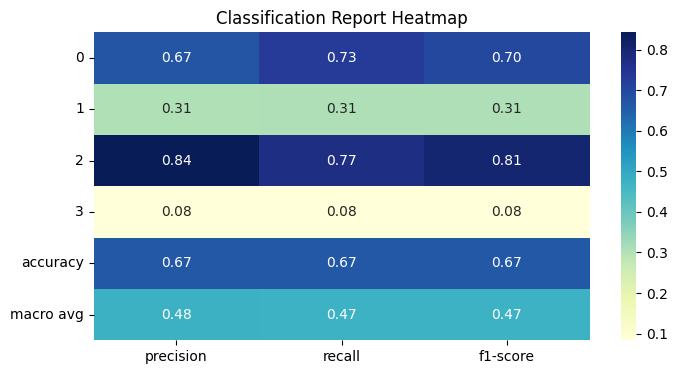

In [63]:


report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).T

plt.figure(figsize=(8,4))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Classification Report Heatmap")
plt.show()


In [64]:
df = train_pciatAvg.copy()
target = "sii_pred"   


### Gender vs PIU Severity Class

Showing counts for: Basic_Demos-Sex (0=Male, 1=Female)


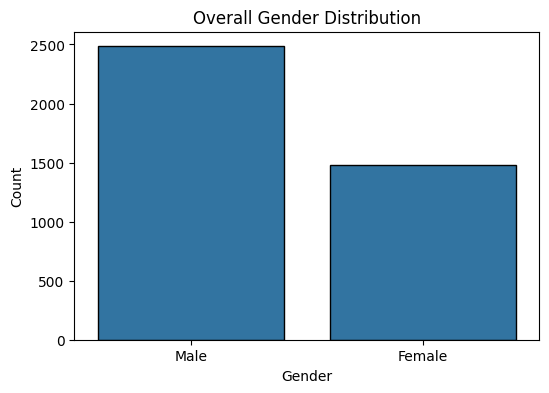

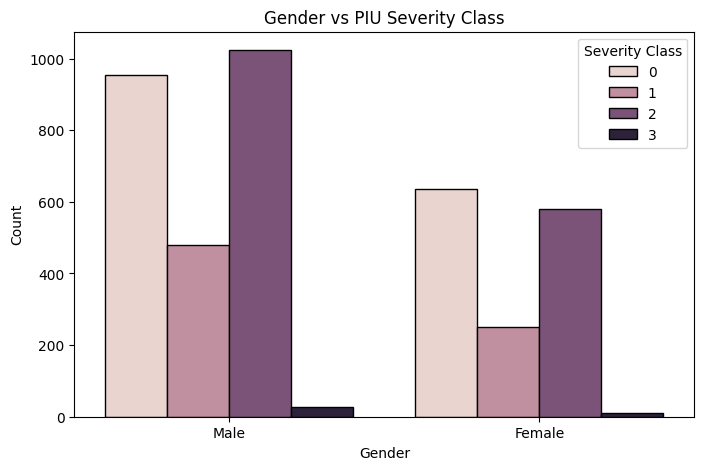

In [65]:
# Pick the first numeric column (excluding target)


col = "Basic_Demos-Sex"

# Map 0/1 to Male/Female
df["Gender"] = df[col].map({0: "Male", 1: "Female"})

print(f"Showing counts for: {col} (0=Male, 1=Female)")

# 1. Overall gender counts
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Gender", edgecolor="black")
plt.title("Overall Gender Distribution")
plt.xlabel("Gender"); plt.ylabel("Count")
plt.show()

# 2. Gender counts broken down by severity class
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="Gender", hue=target, edgecolor="black")
plt.title("Gender vs PIU Severity Class")
plt.xlabel("Gender"); plt.ylabel("Count")
plt.legend(title="Severity Class")
plt.show()



### Age Group vs PIU Severity Clas

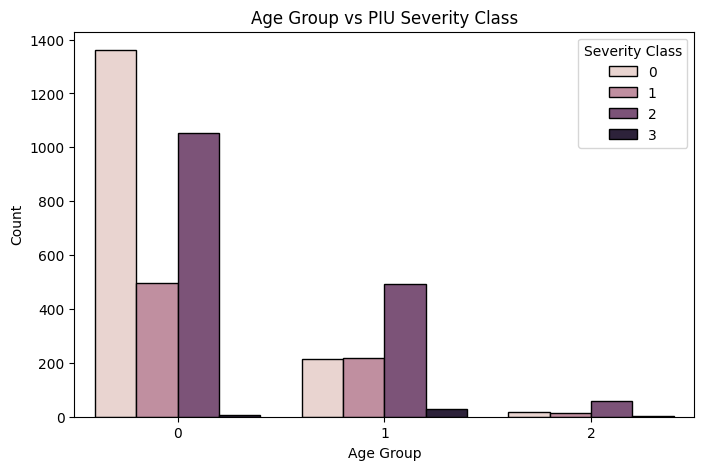

In [66]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="Age_Group", hue=target, edgecolor="black")
plt.title("Age Group vs PIU Severity Class")
plt.xlabel("Age Group"); plt.ylabel("Count")
plt.legend(title="Severity Class")
plt.show()


### Boxplot of PIU Severity by Age Group

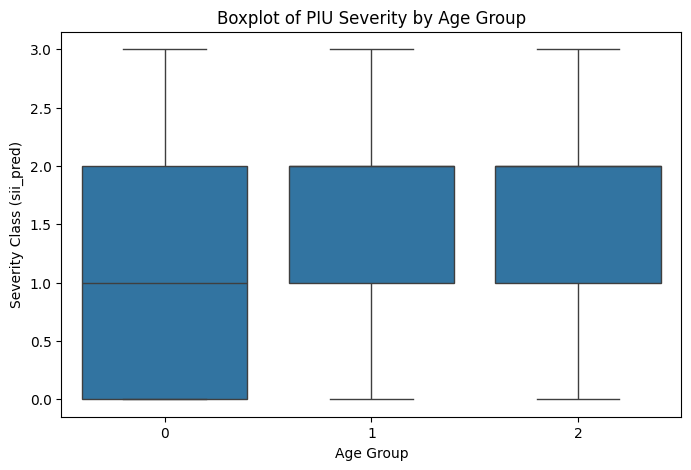

In [67]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="Age_Group", y=target)
plt.title("Boxplot of PIU Severity by Age Group")
plt.xlabel("Age Group"); plt.ylabel("Severity Class (sii_pred)")
plt.show()


### Percentage of PIU Severity within Each Age Group

Percentage of PIU categories within each Age Group (rows sum to 100%):
sii_pred       0      1      2     3
Age_Group                           
0          46.63  17.06  36.11  0.21
1          22.35  22.98  51.84  2.83
2          18.18  13.64  64.77  3.41


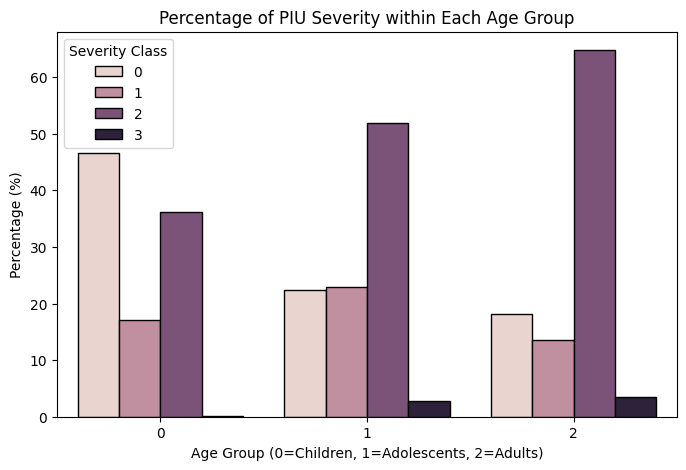

In [68]:


# Make a percentage table: rows = Age_Group, cols = sii_pred, values = %
pct = (pd.crosstab(df["Age_Group"], df["sii_pred"], normalize="index") * 100).round(2)

print("Percentage of PIU categories within each Age Group (rows sum to 100%):")
print(pct)

# ---- Grouped bar chart ----
plt.figure(figsize=(8,5))
sns.barplot(
    data=pct.reset_index().melt(id_vars="Age_Group", var_name="sii_pred", value_name="percentage"),
    x="Age_Group", y="percentage", hue="sii_pred", edgecolor="black"
)
plt.title("Percentage of PIU Severity within Each Age Group")
plt.xlabel("Age Group (0=Children, 1=Adolescents, 2=Adults)")
plt.ylabel("Percentage (%)")
plt.legend(title="Severity Class")
plt.show()



### Relationship Between Problematic Internet Use Features (Spearman Correlation)

In [69]:

# Select only numeric columns
num_df = df.select_dtypes(include=["int64", "float64"])


In [70]:
corr = num_df.corr(method="spearman")


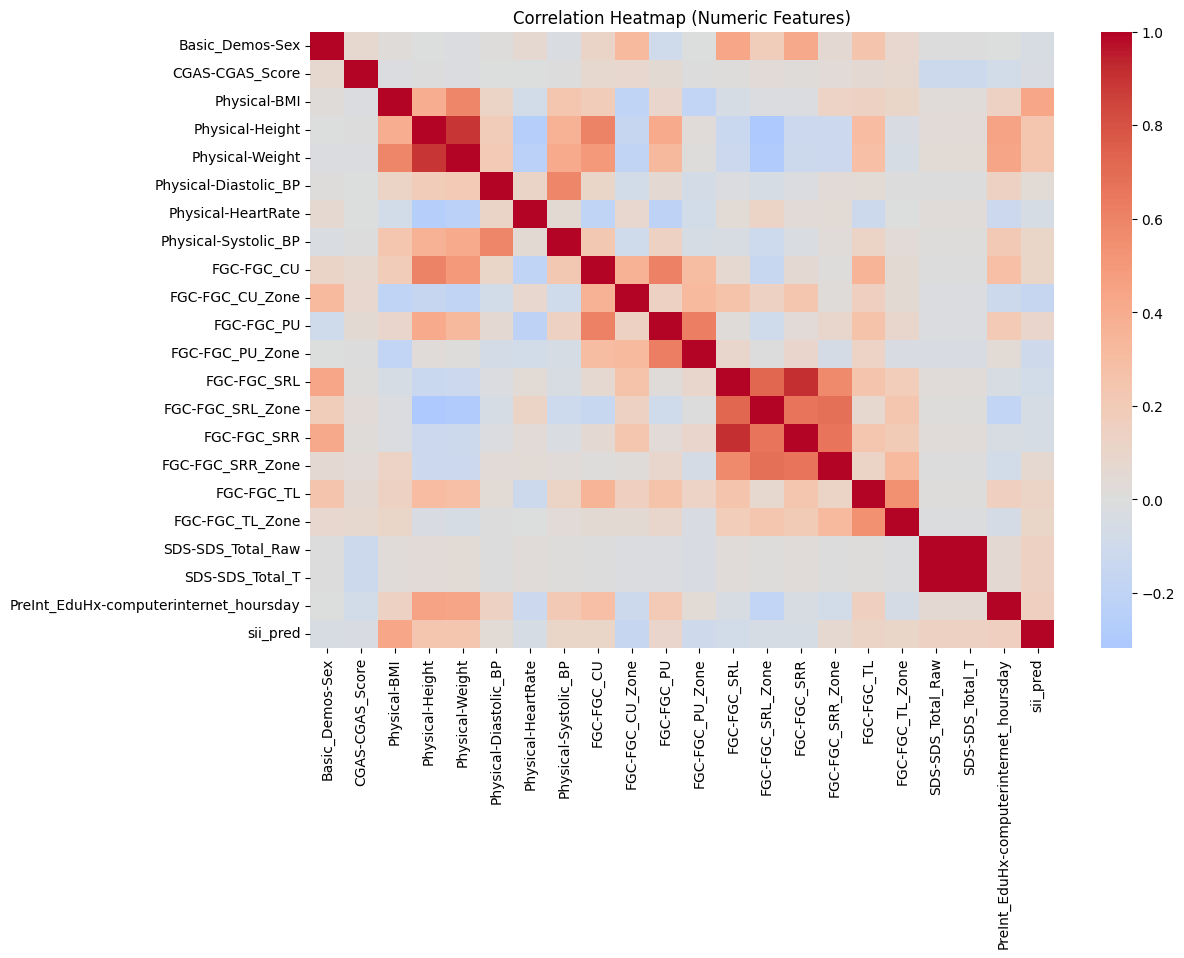

In [71]:
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False, fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


### Conclusion